In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import psutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
df = pd.read_csv("AMZN.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.head())
print(df.columns)

                  Open        High         Low   Adj Close    Volume  \
Date                                                                   
2010-01-04  136.250000  136.610001  133.139999  133.899994   7599900   
2010-01-05  133.429993  135.479996  131.809998  134.690002   8851900   
2010-01-06  134.600006  134.729996  131.649994  132.250000   7178800   
2010-01-07  132.009995  132.320007  128.800003  130.000000  11030200   
2010-01-08  130.559998  133.679993  129.029999  133.520004   9830500   

                 Close  
Date                    
2010-01-04  133.899994  
2010-01-05  134.690002  
2010-01-06  132.250000  
2010-01-07  130.000000  
2010-01-08  133.520004  
Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close'], dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2010-01-04 to 2018-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2265 non-null   float64
 1   High       2265 non-null   float64
 2   Low        2265 non-null   float64
 3   Adj Close  2265 non-null   float64
 4   Volume     2265 non-null   int64  
 5   Close      2265 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 123.9 KB


In [5]:
df.describe()

,Open,High,Low,Adj Close,Volume,Close
count,2265.000000,2265.000000,2265.000000,2265.000000,2.265000e+03,2265.000000
mean,553.000949,558.568702,546.430821,552.743179,4.603646e+06,552.743179
std,470.155920,474.660681,463.993737,469.357785,2.954860e+06,469.357785
min,105.930000,111.290001,105.800003,108.610001,9.844000e+05,108.610001
25%,217.649994,219.979996,214.460007,217.830002,2.786500e+06,217.830002
50%,334.679993,336.760010,328.940002,332.910004,3.872500e+06,332.910004
75%,766.599976,771.219971,761.200012,767.330017,5.425000e+06,767.330017
max,2038.109985,2050.500000,2013.000000,2039.510010,4.242110e+07,2039.510010


In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Open         0
High         0
Low          0
Adj Close    0
Volume       0
Close        0
dtype: int64


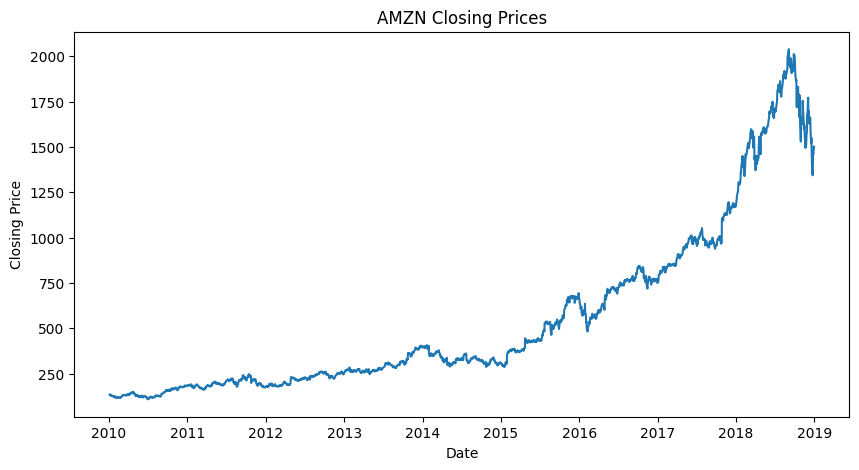

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.title('AMZN Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [8]:
data = df[['Close', 'Adj Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

df_scaled = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

In [9]:
train_size = int(len(df_scaled) * 0.80)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

In [10]:
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + seq_length])
    return np.array(X), np.array(Y)

seq_length = 3
X_train, y_train = create_dataset(train_data.values, seq_length)
X_test, y_test = create_dataset(test_data.values, seq_length)

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(dataset=list(zip(X_train, y_train)), batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=list(zip(X_test, y_test)), batch_size=1, shuffle=False)

In [12]:
def create_deepvar_model(input_dim, hidden_dim, output_dim, num_layers):
    model = nn.Sequential(
        nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True),
        nn.Linear(hidden_dim, output_dim)
    )
    return model

In [13]:
input_dim = 2
hidden_dim = 50
output_dim = 2
num_layers = 1
num_epochs = 1
learning_rate = 0.001

model = create_deepvar_model(input_dim, hidden_dim, output_dim, num_layers)
model[0].h_0 = torch.zeros(num_layers, 1, hidden_dim).requires_grad_()
model[0].c_0 = torch.zeros(num_layers, 1, hidden_dim).requires_grad_()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        h_0, c_0 = model[0].h_0.detach(), model[0].c_0.detach()
        out, (hn, cn) = model[0](inputs, (h_0, c_0))
        out = model[1](out[:, -1, :])
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in test_loader:
        h_0, c_0 = model[0].h_0.detach(), model[0].c_0.detach()
        out, (hn, cn) = model[0](inputs, (h_0, c_0))
        out = model[1](out[:, -1, :])
        predictions.append(out.numpy())
        actuals.append(labels.numpy())

predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()

predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)

print(predictions)

Epoch [1/1], Loss: 0.0003
[[ 872.3366   870.63544]
 [ 869.57806  868.16626]
 [ 868.01056  866.6001 ]
 [ 864.0972   862.45746]
 [ 865.26276  863.7479 ]
 [ 864.7263   863.1765 ]
 [ 867.0812   865.285  ]
 [ 875.993    873.76636]
 [ 886.54395  884.3769 ]
 [ 897.3568   895.255  ]
 [ 903.1122   900.90094]
 [ 913.21747  910.8053 ]
 [ 921.1818   918.7555 ]
 [ 924.90674  922.99335]
 [ 921.08356  919.3206 ]
 [ 919.0561   916.82886]
 [ 920.6029   918.3963 ]
 [ 922.00464  920.1611 ]
 [ 914.7393   913.10443]
 [ 913.26697  911.1509 ]
 [ 915.24835  912.8487 ]
 [ 921.36194  919.35913]
 [ 921.29266  919.2648 ]
 [ 919.4788   917.44885]
 [ 921.91187  919.7304 ]
 [ 923.66516  921.39545]
 [ 927.70044  925.54144]
 [ 930.9543   928.5798 ]
 [ 936.6437   934.1171 ]
 [ 949.11835  946.1773 ]
 [ 959.3837   956.524  ]
 [ 966.3712   964.05206]
 [ 962.82635  960.5839 ]
 [ 958.33575  956.0818 ]
 [ 960.0306   957.37195]
 [ 964.9282   962.08264]
 [ 970.9731   968.46387]
 [ 970.7399   968.33704]
 [ 972.6653   969.8728 ]

In [14]:
var_mse_close = mean_squared_error(actuals[:, 0], predictions[:, 0])
var_rmse_close = np.sqrt(var_mse_close)
var_mae_close = mean_absolute_error(actuals[:, 0], predictions[:, 0])

var_mse_volume = mean_squared_error(actuals[:, 1], predictions[:, 1])
var_rmse_volume = np.sqrt(var_mse_volume)
var_mae_volume = mean_absolute_error(actuals[:, 1], predictions[:, 1])

print(f'DeepVAR Close MSE: {var_mse_close}')
print(f'DeepVAR Close RMSE: {var_rmse_close}')
print(f'DeepVAR Close MAE: {var_mae_close}')


print(f'DeepVAR Volume MSE: {var_mse_volume}')
print(f'DeepVAR Volume RMSE: {var_rmse_volume}')
print(f'DeepVAR Volume MAE: {var_mae_volume}')

DeepVAR Close MSE: 1530.1171875
DeepVAR Close RMSE: 39.1167106628418
DeepVAR Close MAE: 28.70534324645996
DeepVAR Volume MSE: 1547.767333984375
DeepVAR Volume RMSE: 39.3416748046875
DeepVAR Volume MAE: 28.522974014282227


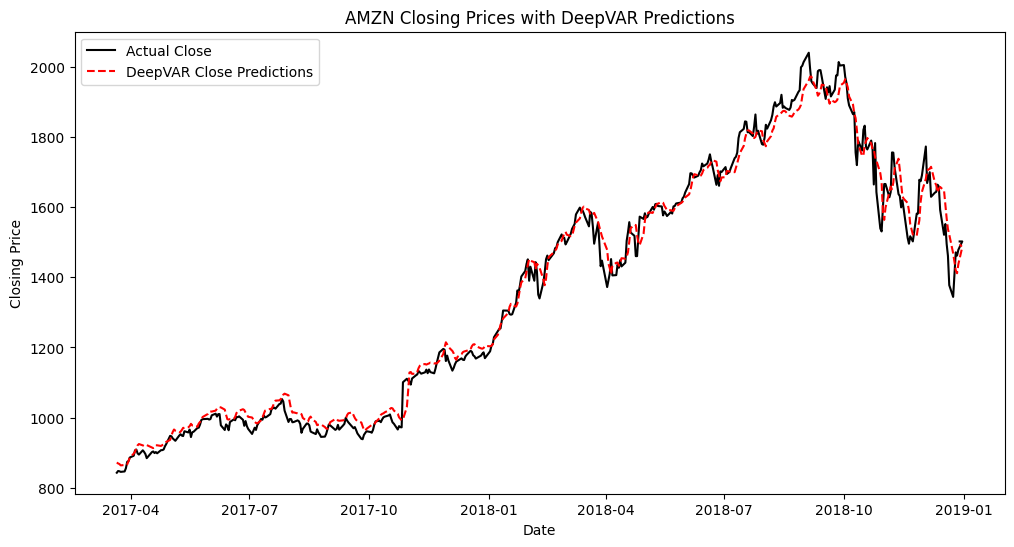

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq_length:], actuals[:, 0], label='Actual Close', color='black')
plt.plot(data.index[train_size+seq_length:], predictions[:, 0], label='DeepVAR Close Predictions', linestyle='dashed', color='red')
plt.title('AMZN Closing Prices with DeepVAR Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

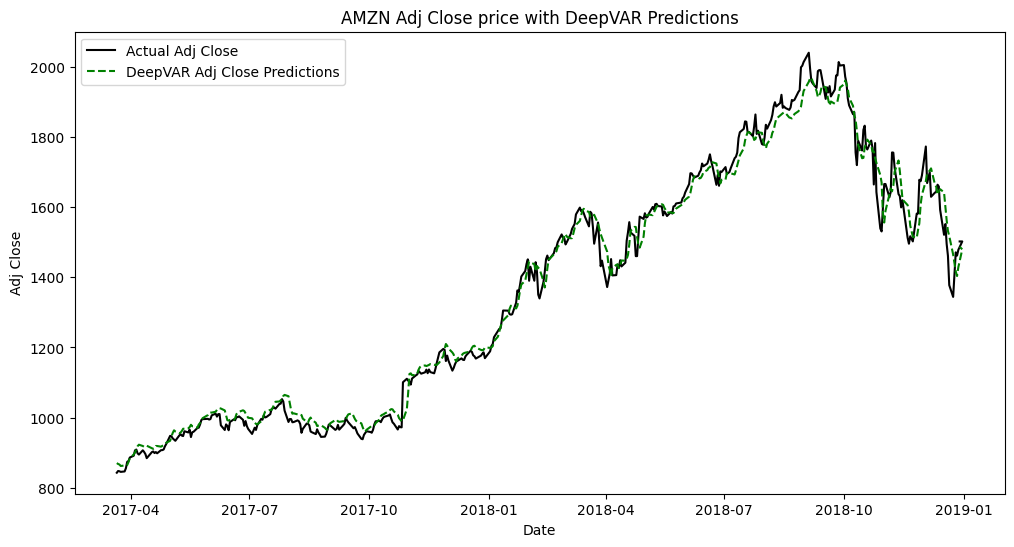

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq_length:], actuals[:, 1], label='Actual Adj Close', color='black')
plt.plot(data.index[train_size+seq_length:], predictions[:, 1], label='DeepVAR Adj Close Predictions', linestyle='dashed', color='green')
plt.title('AMZN Adj Close price with DeepVAR Predictions')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [17]:
model.eval()
future_predictions = []

last_seq = torch.tensor(test_data.values[-seq_length:], dtype=torch.float32).unsqueeze(0)

start_time = time.time()
process = psutil.Process()

initial_cpu_times = process.cpu_times()
initial_memory_info = process.memory_info()

with torch.no_grad():
    for _ in range(365):
        h_0, c_0 = model[0].h_0.detach(), model[0].c_0.detach()
        next_pred, (hn, cn) = model[0](last_seq, (h_0, c_0))
        next_pred = model[1](next_pred[:, -1, :])
        future_predictions.append(next_pred.numpy())
        last_seq = torch.cat((last_seq[:, 1:, :], next_pred.unsqueeze(0)), dim=1)

end_time = time.time()
prediction_duration = end_time - start_time

cpu_time = process.cpu_times()
memory = process.memory_info()

cpu_time_user = cpu_time.user - initial_cpu_times.user
cpu_time_system = cpu_time.system - initial_cpu_times.system
memory_usage = memory.rss - initial_memory_info.rss  

print(f"Prediction duration: {prediction_duration:.2f} seconds")
print(f"CPU time (user): {cpu_time_user:.2f} seconds")
print(f"CPU time (system): {cpu_time_system:.2f} seconds")
print(f"Memory usage: {memory_usage / (1024 * 1024):.2f} MB")

future_predictions = np.array(future_predictions).squeeze()
future_predictions = scaler.inverse_transform(future_predictions)

Prediction duration: 0.18 seconds
CPU time (user): 0.44 seconds
CPU time (system): 0.06 seconds
Memory usage: 0.12 MB


In [18]:
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)

for date, prediction in zip(future_dates, future_predictions):
    print(f'Date: {date.date()} - Predicted Close Price: ${prediction[0]:.2f} - Predicted Adj Close: {prediction[1]:.0f}')

Date: 2018-12-30 - Predicted Close Price: $1507.47 - Predicted Adj Close: 1501
Date: 2018-12-31 - Predicted Close Price: $1516.90 - Predicted Adj Close: 1511
Date: 2019-01-01 - Predicted Close Price: $1520.09 - Predicted Adj Close: 1514
Date: 2019-01-02 - Predicted Close Price: $1524.71 - Predicted Adj Close: 1518
Date: 2019-01-03 - Predicted Close Price: $1530.41 - Predicted Adj Close: 1524
Date: 2019-01-04 - Predicted Close Price: $1534.46 - Predicted Adj Close: 1528
Date: 2019-01-05 - Predicted Close Price: $1538.99 - Predicted Adj Close: 1533
Date: 2019-01-06 - Predicted Close Price: $1543.52 - Predicted Adj Close: 1537
Date: 2019-01-07 - Predicted Close Price: $1547.58 - Predicted Adj Close: 1541
Date: 2019-01-08 - Predicted Close Price: $1551.69 - Predicted Adj Close: 1545
Date: 2019-01-09 - Predicted Close Price: $1555.67 - Predicted Adj Close: 1549
Date: 2019-01-10 - Predicted Close Price: $1559.46 - Predicted Adj Close: 1553
Date: 2019-01-11 - Predicted Close Price: $1563.17 -

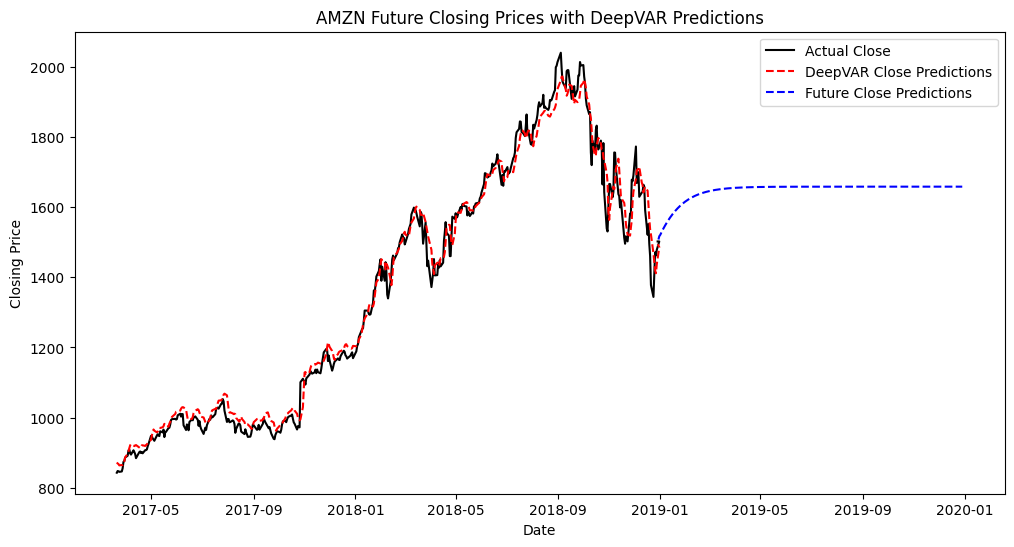

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq_length:], actuals[:, 0], label='Actual Close', color='black')
plt.plot(data.index[train_size+seq_length:], predictions[:, 0], label='DeepVAR Close Predictions', linestyle='dashed', color='red')
plt.plot(future_dates, future_predictions[:, 0], label='Future Close Predictions', linestyle='dashed', color='blue')
plt.title('AMZN Future Closing Prices with DeepVAR Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

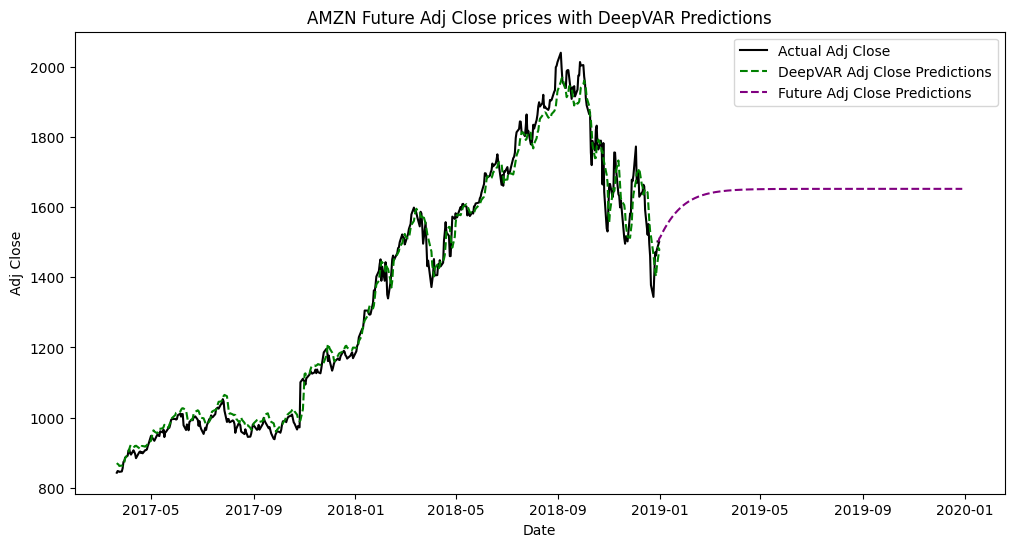

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq_length:], actuals[:, 1], label='Actual Adj Close', color='black')
plt.plot(data.index[train_size+seq_length:], predictions[:, 1], label='DeepVAR Adj Close Predictions', linestyle='dashed', color='green')
plt.plot(future_dates, future_predictions[:, 1], label='Future Adj Close Predictions', linestyle='dashed', color='purple')
plt.title('AMZN Future Adj Close prices with DeepVAR Predictions')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()